# <center> Stochastic Optimization and Automatic Differentiation for Machine Learning<br/><br/>SDCA<br/><br/>Zakarya Ali</center>



In this notebook, I implement the **SDCA (Stochastic Dual Coordinate Ascent)** algorithm (from the article [Stochastic Dual Coordinate Ascent Methods for Regularized Loss Minimization by Shai Shalev-Shwartz  and Tong Zhang](http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf) to estimate Support Vector Machines. First, I apply the algorithm on randomly generated data, then I use a credit fraud dataset to compare **SDCA** compare it with **PEGASOS (Primal Estimated subGrAdient SOlver for SVM)**, a sub-gradient descent approach.

We use the following terms :
- $X_1,..,X_n \in \mathbb{R}^d$ are the explanatory variables for the n observations
- $y_1,..,y_n \in \{-1,1\}$  are the associated labels
- $ \lambda $ is the SDCA regularization term
- $ w \in \mathbb{R} $ is the parameter to optimize
- $ \phi_i(a)=max(0,1-y_ia) $ the Hinge loss linked to the SVM

# Prerequisites

We call and create the tools we will need throughout the notebook.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(2018)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def hinge_losses(y, X, w, n_samples):
    """Compute the sum of individual hinge losses"""
    return np.sum(np.fmax(np.zeros(n_samples), np.ones(n_samples) - (y * (X.dot(w)))))

def get_accuracy(X, y, w):
    """Return the accuracy of linear SVM for a given parameter w"""
    preds = np.dot(X, w)
    preds[preds >= 0] = 1
    preds[preds < 0] = -1
    return accuracy_score(y, preds)

def convergence_plot(plot_data, labels, ylim=[None, None]):
    """plot the convergence of various primal curves"""
    fig=plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    if (ylim != [None, None]):
        ax.set_ylim(ylim)
    for i in range(len(labels)) :
        plt.plot(plot_data[i], label = labels[i])
    plt.title("Convergence plot")
    plt.ylabel("Primal Objective")
    plt.xlabel("Steps")
    plt.legend(loc="best")
    plt.show()

# I. Algorithms

## I.1. SDCA Implementation

In [3]:
def primal_param(X, alpha, lambda_, n_samples):
    """Return the primal parameter w associated to a dual parameter alpha"""
    return (1 / (lambda_ * n_samples)) * (np.dot(np.transpose(X), alpha))

def get_delta_alpha_q(X, y, alpha, q, lambda_, n_samples, w):
    """Compute SDCA update"""
    A = (1 / (lambda_ * n_samples)) * (np.dot(np.transpose(X[q]), X[q]))
    B = np.dot(np.transpose(X[q]) , w)
    delta_alpha_tilde_q = (y[q] - B) / A
    return y[q] * max(0 , min(1 , y[q]*(delta_alpha_tilde_q + alpha[q]))) - alpha[q] 

In [4]:
#Here is the code for the different SDCA implementation (random, cyclic and permutation)

def sdca_svm_random(X, y, n_samples, T_0, lambda_, nb_epochs=50):

    # initialization 
    alpha = np.zeros(n_samples)
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambda_, n_samples)

    for t in range(n_samples * nb_epochs):
        q = np.random.randint(0, n_samples)
        # SDCA update step
        delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambda_, n_samples, w)
        e = np.zeros(n_samples)
        e[q] = 1
        sdca_update = e * delta_alpha_q
        alpha = alpha + sdca_update
        w = primal_param(X, alpha, lambda_, n_samples)

        w_history.append(w)
        primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    
def sdca_svm_permutation(X, y, n_samples, T_0, lambda_, nb_epochs=50):

    # initialization 
    alpha = np.zeros(n_samples)
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambda_, n_samples)
    
    count = 0
    for t in range(nb_epochs):
        perm = np.random.permutation(n_samples)
        for q in perm :
            # SDCA update step
            delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambda_, n_samples, w)
            e = np.zeros(n_samples)
            e[q] = 1
            sdca_update = e * delta_alpha_q
            alpha = alpha + sdca_update
            w = primal_param(X, alpha, lambda_, n_samples)

            w_history.append(w)
            primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)
            count +=1

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

def sdca_svm_cyclic(X, y, n_samples, T_0, lambda_, nb_epochs=50):

    # initialization 
    alpha = np.zeros(n_samples)
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambda_, n_samples)
    
    count = 0
    perm = np.random.permutation(n_samples)
    for t in range(nb_epochs):
        for q in perm :
            # SDCA update step
            delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambda_, n_samples, w)
            e = np.zeros(n_samples)
            e[q] = 1
            sdca_update = e * delta_alpha_q
            alpha = alpha + sdca_update
            w = primal_param(X, alpha, lambda_, n_samples)

            w_history.append(w)
            primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)
            count +=1
                
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

## I.2. Pegasos implementation

Main difference with SDCA : 
- We compute sub-gradients and not gradients at each steps 
- The step size is always $\frac{1}{\lambda t}$

In [5]:
def partial_sub_gradient(w, X, y, q, lambda_):
    """Partial Subgradient for the hinge-loss"""
    if ( y[q]*np.dot(w, X[q]) < 1 ):
        return lambda_ * w - y[q] * X[q]
    else:
        return lambda_ * w

In [6]:
def pegasos_svm(X, y, n_samples, T_0, lambda_, nb_epochs=50, proj=False):
    """Compute the PEGASOS SVM for both projection and non projection options"""
    # initialization 
    w = np.zeros(X.shape[1])
    w_history = []
    primal_history = []
    
    for t in range(1, n_samples * nb_epochs):
        # compute Pegasos step size
        step_size = 1 / (lambda_ * t)
        # pick random sample
        q = np.random.randint(0, n_samples)
        # compute and apply Pegasos update rule
        w = w - step_size * partial_sub_gradient(w, X, y, q, lambda_)
        # projection step (optional)
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambda_) * np.linalg.norm(w))) * w
        
        w_history.append(w)        
        primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)
        
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

 ## I.3. Accelerated mini-batch SDCA (ASDCA) implementation
For accelerated mini-batch SDCA, the smooth version of the hinge loss is used.

In [7]:
def partial_gradient_smooth(w, X, y, q):
    """Gradient of the smooth hinge loss"""
    results = np.zeros(X.shape[1])
    partial_gradient = y[q] * np.dot(X[q], w)
    
    if (0 <= partial_gradient <= 1 ):
        results = (partial_gradient - 1) * y[q] * X[q]
    elif (y[q] * np.dot(w, X[q]) < 0 ):
        results = - y[q] * X[q]
    
    return results

In [8]:
def asdca_svm(X, y, n_samples, T_0, lambda_, batch_size, theta=0.3, nb_epochs=50):

    # initialization
    alpha = np.zeros(shape = (X.shape[1], n_samples))
    bar_alpha = np.mean(alpha, axis=1)
    w = np.zeros(X.shape[1])
    w_history = []
    primal_history = []

    for t in range(n_samples * nb_epochs):
        u = (1 - theta) * w + (theta / lambda_) * bar_alpha
        # mini-batch sampling
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        alpha_dif = []
        # update step
        for q in batch:
            old_alpha_q = alpha[:,q].copy()
            alpha[:,q] = (1 - theta) * alpha[:,q] - theta * partial_gradient_smooth(u, X, y, q)
            alpha_dif.append(alpha[:,q] - old_alpha_q)
        bar_alpha = bar_alpha + (1 / n_samples) * sum(alpha_dif, axis=0)
        w = (1 - theta) * w + (theta / lambda_) * bar_alpha
        
        w_history.append(w)
        primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history


## I.4. Mini-batch Pegasos implementation

In [9]:
def mini_batch_pegasos_svm(X, y, n_samples, T_0, lambda_, batch_size, nb_epochs=50, proj=False):

    # initialization
    w = np.zeros(X.shape[1])
    w_history = []
    primal_history = []
    
    # main loop
    for t in range(1, n_samples * nb_epochs):
        step_size = 1 / (lambda_ * t)
        # mini-batch sampling
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        sum_vect = []
        for q in batch:
            if (y[q] * np.dot(X[q], w) < 1):
                sum_vect.append(y[q] * X[q])
            else:
                sum_vect.append(np.zeros(X.shape[1]))
                
        w = w - step_size * (lambda_ * w - (1 / batch_size) * sum(sum_vect, axis=0))
        # Projection step
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambda_) * np.linalg.norm(w))) * w
            
        w_history.append(w)
        primal_history.append(hinge_losses(y, X, w, n_samples) / n_samples + (lambda_ / 2) * np.linalg.norm(w)**2)
    
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history


# II. Application: Simulated data
We now apply those algorithms on simulated data: 1000 observations with 100 features.

In [10]:
n_samples, n_features = 1000, 100
# Feature matrix
X = np.random.randn(n_samples, n_features)
# ground truth parameter
beta = np.random.randn(n_features)
# Binary label vector
y = np.dot(X, beta) + np.random.randn(n_samples)
y[y >= 0] = 1
y[y < 0] = -1

In [11]:
# We normalize the features before applying SVM
X_std = preprocessing.StandardScaler().fit_transform(X)

# Then we split our dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)
n_samples_train = X_train.shape[0]

## II.1. SDCA

In [12]:
# SDCA Random
opt_w_sdca_r, w_hist_sdca_r, primal_hist_sdca_r = sdca_svm_random(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambda_=1 / n_samples)
#SDCA Permutation
opt_w_sdca_p, w_hist_sdca_p, primal_hist_sdca_p = sdca_svm_permutation(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambda_=1 / n_samples)
#SDCA Cyclic
opt_w_sdca_c, w_hist_sdca_c, primal_hist_sdca_c = sdca_svm_cyclic(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambda_=1 / n_samples)

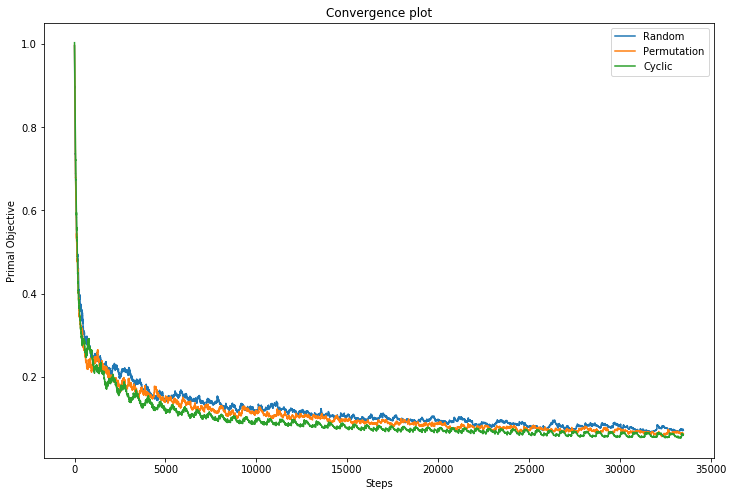

In [13]:
convergence_plot([primal_hist_sdca_r, primal_hist_sdca_p, primal_hist_sdca_c], 
                 ["Random", "Permutation", "Cyclic"])

In [14]:
# Prediction accuracy on test set
print("SDCA Random:", get_accuracy(X_test, y_test, w_hist_sdca_r[-1]))
print("SDCA Permutation:", get_accuracy(X_test, y_test, w_hist_sdca_p[-1]))
print("SDCA Cyclic:", get_accuracy(X_test, y_test, w_hist_sdca_c[-1]))
print("SDCA Average Random:", get_accuracy(X_test, y_test, opt_w_sdca_r))
print("SDCA Average Permutation:", get_accuracy(X_test, y_test, opt_w_sdca_p))
print("SDCA Average Cyclic:", get_accuracy(X_test, y_test, opt_w_sdca_c))
print("True:", get_accuracy(X_test, y_test, beta))

SDCA Random: 0.9121212121212121
SDCA Permutation: 0.9303030303030303
SDCA Cyclic: 0.9151515151515152
SDCA Average Random: 0.9181818181818182
SDCA Average Permutation: 0.9333333333333333
SDCA Average Cyclic: 0.9242424242424242
True: 0.9454545454545454


## II.2. PEGASOS

In [15]:
#Non projected PEGASOS
opt_w_peg, w_hist_peg, primal_hist_peg = pegasos_svm(X_train, y_train,
                                                        n_samples_train, T_0=50 * n_samples // 2,
                                                        lambda_=1 / n_samples, proj=False)
#Projected PEGASOS
opt_w_peg_p, w_hist_peg_p, primal_hist_peg_p = pegasos_svm(X_train, y_train,
                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                            lambda_=1 / n_samples, proj=True)

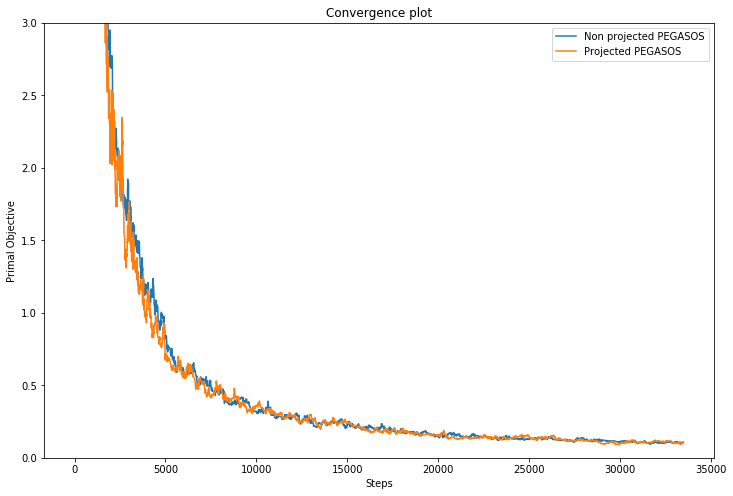

In [16]:
convergence_plot([primal_hist_peg, primal_hist_peg_p], 
                 ["Non projected PEGASOS", "Projected PEGASOS"], 
                 ylim=[0,3])

In [17]:
# Prediction accuracy on test set
print("Non projected PEGASOS", get_accuracy(X_test, y_test, w_hist_peg[-1]))
print("Projected PEGASOS", get_accuracy(X_test, y_test, w_hist_peg_p[-1]))
print("Average PEGASOSO", get_accuracy(X_test, y_test, opt_w_peg))
print("Average projected PEGASOS", get_accuracy(X_test, y_test, opt_w_peg_p))
print("True", get_accuracy(X_test, y_test, beta))

Non projected PEGASOS 0.9151515151515152
Projected PEGASOS 0.9030303030303031
Average PEGASOSO 0.9181818181818182
Average projected PEGASOS 0.9121212121212121
True 0.9454545454545454


## II.3. Accelerated mini-batch SDCA

In [18]:
# ASDCA
opt_w_sdca_batch, w_hist_sdca_batch, primal_hist_sdca_batch = asdca_svm(X_train, y_train, 
                                                                        n_samples_train, T_0=50 * n_samples // 2, 
                                                                        lambda_=1 / n_samples, batch_size = 8, theta = 0.15)

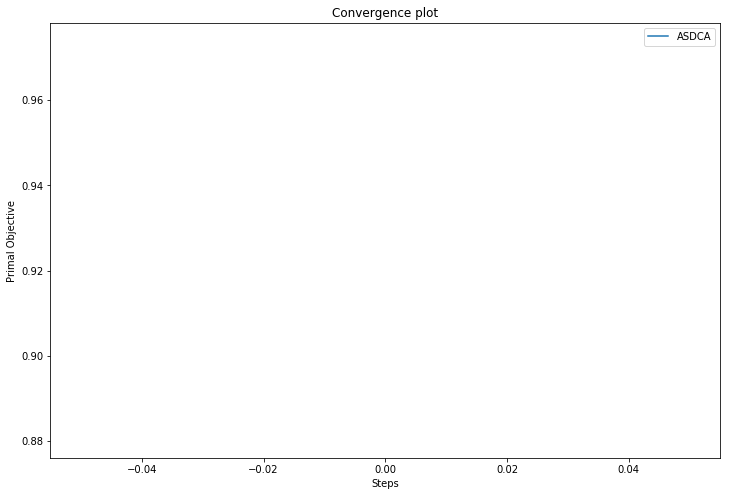

In [19]:
convergence_plot(primal_hist_sdca_batch, 
                 ["ASDCA"])

In [20]:
# Computing prediction accuracy on test set
print("ASDCA", get_accuracy(X_test, y_test, w_hist_sdca_batch[-1]))
print("Average ASDCA", get_accuracy(X_test, y_test, opt_w_sdca_batch))
print("True", get_accuracy(X_test, y_test, beta))

ASDCA 0.8818181818181818
Average ASDCA 0.9030303030303031
True 0.9454545454545454


## II.4. Mini-batch PEGASOS

In [21]:
# Mini-batch PEGASOS
opt_w_peg_batch, w_hist_peg_batch, primal_hist_peg_batch = mini_batch_pegasos_svm(X_train, y_train, 
                                                                                  n_samples_train, T_0=50 * n_samples // 2,
                                                                                lambda_=1 / n_samples, batch_size=8, proj=False)
# Mini-batch PEGASOS (Projected)
opt_w_peg_batch_p, w_hist_peg_batch_p, primal_hist_peg_batch_p = mini_batch_pegasos_svm(X_train, y_train, 
                                                                                        n_samples_train, T_0=50 * n_samples // 2, 
                                                                                        lambda_=1 / n_samples, batch_size=8, proj=True)

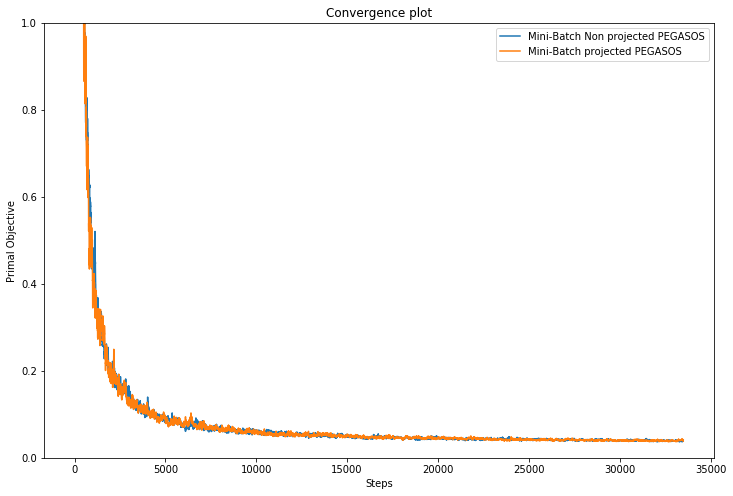

In [22]:
convergence_plot([primal_hist_peg_batch, primal_hist_peg_batch_p], 
                 ["Mini-Batch Non projected PEGASOS", "Mini-Batch projected PEGASOS"],
                 ylim=[0,1])

In [23]:
# Computing prediction accuracy on test set
print("Mini Batch PEGASOS", get_accuracy(X_test, y_test, w_hist_peg_batch[-1]))
print("Mini Batch PEGASOS (Projected)", get_accuracy(X_test, y_test, w_hist_peg_batch_p[-1]))
print("Average Mini Batch PEGASOS", get_accuracy(X_test, y_test, opt_w_peg_batch))
print("Average Mini Batch PEGASOS (Projected)", get_accuracy(X_test, y_test, opt_w_peg_batch_p))
print("True", get_accuracy(X_test, y_test, beta))

Mini Batch PEGASOS 0.9212121212121213
Mini Batch PEGASOS (Projected) 0.9121212121212121
Average Mini Batch PEGASOS 0.9181818181818182
Average Mini Batch PEGASOS (Projected) 0.9242424242424242
True 0.9454545454545454


## II.5. Results comparison

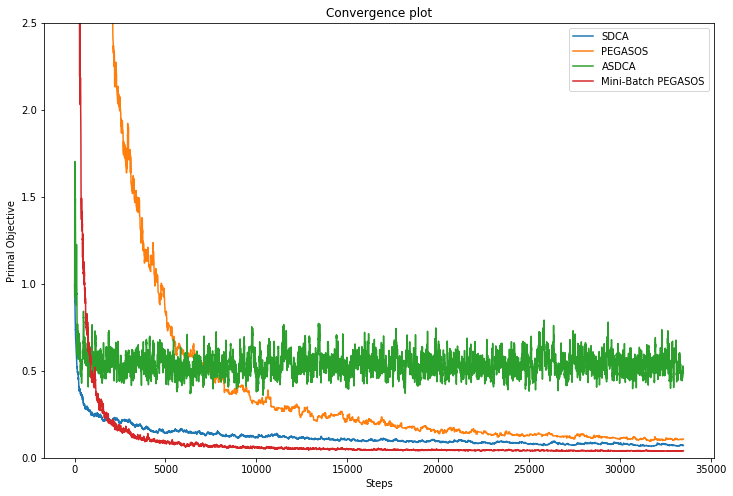

In [24]:
# Convergence comparison :
convergence_plot([primal_hist_sdca_r, primal_hist_peg, primal_hist_sdca_batch, primal_hist_peg_batch],
                 ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"], 
                 ylim = [0, 2.5])

# III. Application: Credit Fraud detection (highly unbalanced dataset)

This is a dataset from a Kaggle competition : https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [25]:
def rework_labels(label):
    result = label
    if label == 0:
        result = -1
    return result

data = pd.read_csv("data/creditcard.csv")
data = data.dropna()
print(data.shape)
X = data.drop(columns=["Class"])
y = data["Class"].apply(rework_labels)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Our dataset contain 30 features and 284807 observations.

In [26]:
X.shape

(284807, 30)

In [27]:
y.shape

(284807,)

In [28]:
# Standardisation of features is required before SVM :
X_std = preprocessing.StandardScaler().fit_transform(X)

In [29]:
# Train test split for this dataset :
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, stratify=y, random_state=2018)

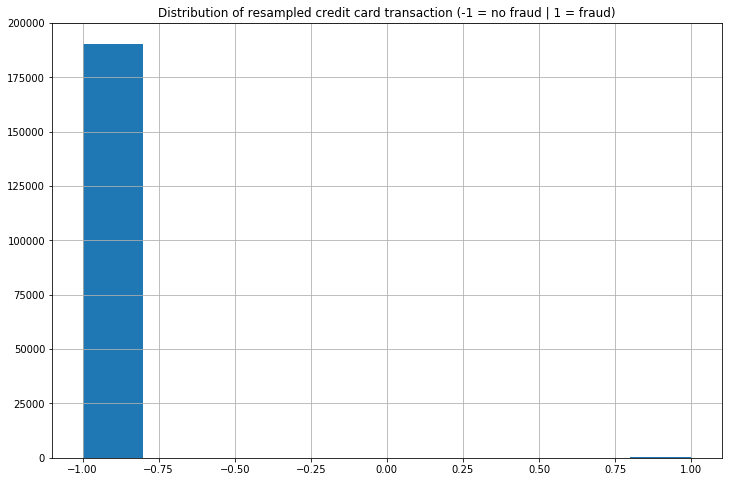

In [30]:
plt.figure(figsize=(12,8))
y_train.hist()
plt.title('Distribution of resampled credit card transaction (-1 = no fraud | 1 = fraud)')
plt.show()

The problem is highly unbalanced (0.175% of credit fraud in the dataset)

We undersample the majority class in order to get a better training set.

In [31]:
rus = RandomUnderSampler(random_state=42, ratio={-1: 1000})
X_res, y_res = rus.fit_sample(X_train, y_train)
n_samples = X_res.shape[0]

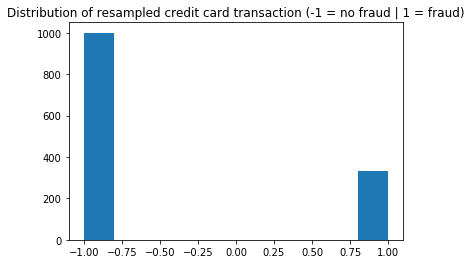

In [32]:
plt.hist(y_res)
plt.title('Distribution of resampled credit card transaction (-1 = no fraud | 1 = fraud)')
plt.show()

In [33]:
y_res.shape

(1330,)

In [34]:
X_res.shape

(1330, 30)

## III.1. SDCA

In [36]:
#SDCA Random
gen_opt_w_sdca_avg_r, gen_w_hist_sdca_avg_r, gen_primal_hist_sdca_avg_r = sdca_svm_random(X_res, y_res, 
                                                                                          n_samples, T_0=50 * n_samples // 2, 
                                                                                          lambda_=50) 
#SDCA Permutation
gen_opt_w_sdca_avg_p, gen_w_hist_sdca_avg_p, gen_primal_hist_sdca_avg_p = sdca_svm_permutation(X_res, y_res, 
                                                                                               n_samples, T_0=50 * n_samples // 2, 
                                                                                               lambda_=50)
#SDCA Cyclic
gen_opt_w_sdca_avg_c, gen_w_hist_sdca_avg_c, gen_primal_hist_sdca_avg_c = sdca_svm_cyclic(X_res, y_res, 
                                                                                          n_samples, T_0=50 * n_samples // 2, 
                                                                                          lambda_=50)

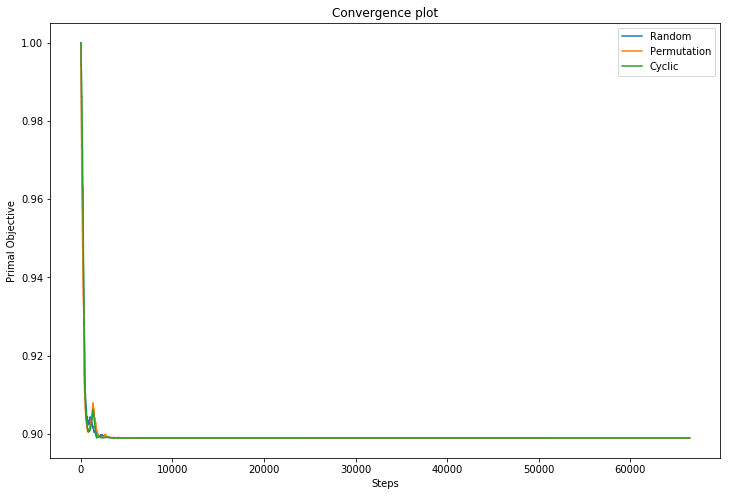

In [37]:
convergence_plot([gen_primal_hist_sdca_avg_r, gen_primal_hist_sdca_avg_p, gen_primal_hist_sdca_avg_c],
                 ["Random", "Permutation", "Cyclic"])

## III.2. PEGASOS

In [38]:
#PEGASOS
gen_opt_w_peg_avg, gen_w_hist_peg_avg, gen_primal_hist_peg_avg = pegasos_svm(X_res, y_res, 
                                                                             n_samples, T_0=50 * n_samples // 2, 
                                                                             lambda_=50, proj=False)
#PEGASOS (Projected)
gen_opt_w_peg_avg_proj, gen_w_hist_peg_avg_proj, gen_primal_hist_peg_avg_proj = pegasos_svm(X_res, y_res, 
                                                                                            n_samples, T_0=50 * n_samples // 2, 
                                                                                            lambda_=50, proj=True)

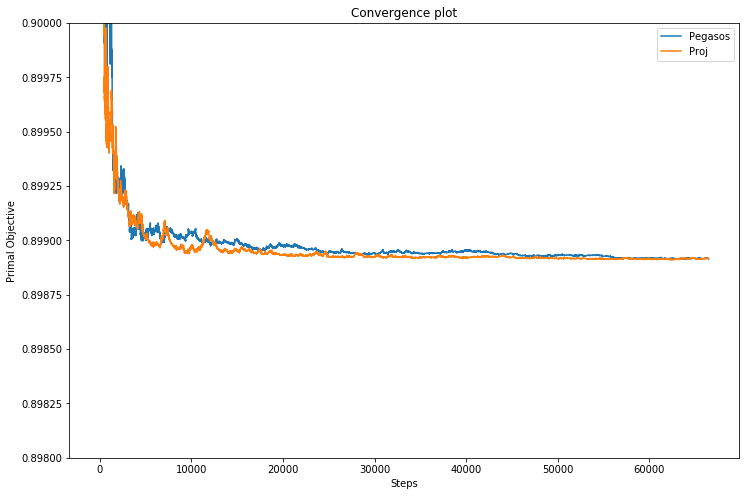

In [39]:
convergence_plot([gen_primal_hist_peg_avg, gen_primal_hist_peg_avg_proj], 
                 ["Pegasos", "Proj"], 
                 ylim=[0.898, 0.9])

## III.3. Accelerated mini-batch SDCA (ASDCA)

In [42]:
#ASDCA
gen_opt_w_sdca_batch_avg, gen_w_hist_sdca_batch_avg, gen_primal_hist_sdca_batch_avg = asdca_svm(X_res, y_res, 
                                                                                              n_samples, T_0=50 * n_samples // 2, 
                                                                                              lambda_=50, batch_size = 8, theta = 0.15)

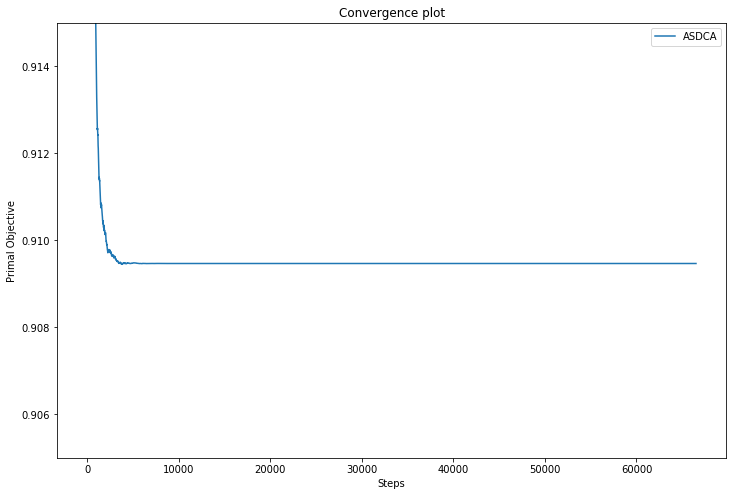

In [43]:
convergence_plot([gen_primal_hist_sdca_batch_avg], 
                 ["ASDCA"], 
                 ylim=[0.905, 0.915])

## III.4. Mini-batch PEGASOS

In [44]:
#Mini-batch PEGASOS
gen_opt_w_peg_batch_avg, gen_w_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg = mini_batch_pegasos_svm(X_res, y_res, 
                                                                                                          n_samples, T_0=50 * n_samples // 2, 
                                                                                                          lambda_=50, batch_size=8, proj=False)
#Mini-batch PEGASOS (Projected)
gen_opt_w_peg_batch_avg_proj, gen_w_hist_peg_batch_avg_proj, gen_primal_hist_peg_batch_avg_proj = mini_batch_pegasos_svm(X_res, y_res, n_samples, 
                                                                                                                         T_0=50 * n_samples // 2, 
                                                                                                                         lambda_=50, batch_size=8, proj=False)

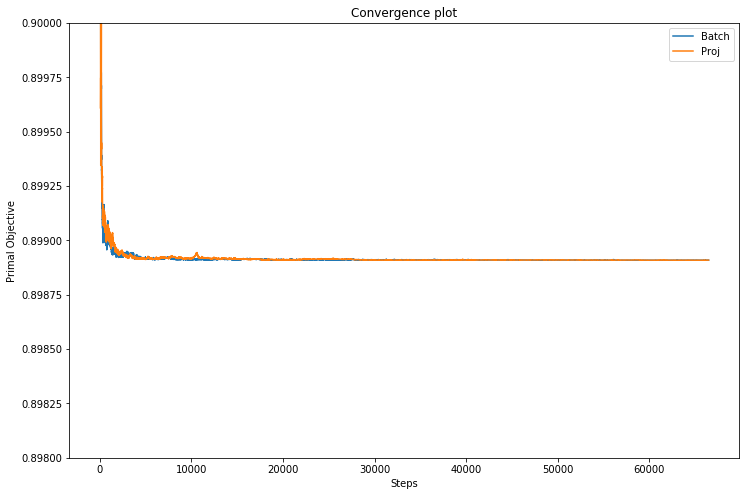

In [45]:
convergence_plot([gen_primal_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg_proj], 
                ["Batch", "Proj"], 
                ylim=[0.898, 0.9])

## III.5. Comparison

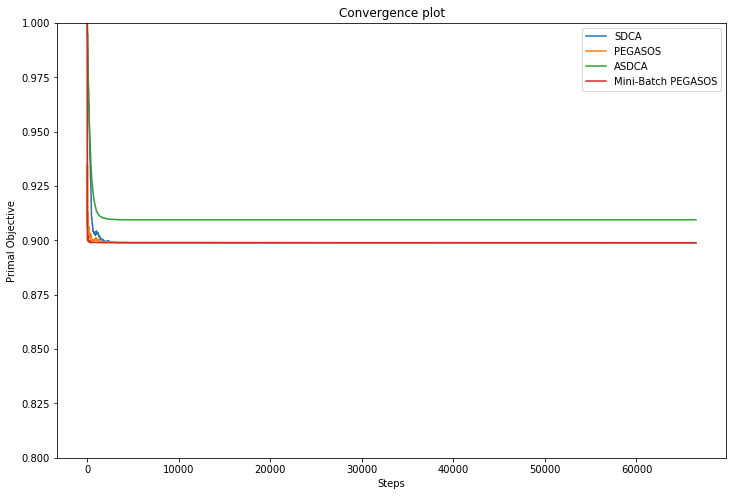

In [46]:
convergence_plot([gen_primal_hist_sdca_avg_r, gen_primal_hist_peg_avg, gen_primal_hist_sdca_batch_avg, gen_primal_hist_peg_batch_avg],
                 ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"], 
                 ylim = [0.8, 1])

## III.6 Accuracy

In [47]:
# Prediction accuracy on test set
print("SDCA:", get_accuracy(X_test, y_test, gen_w_hist_sdca_avg_r[-1]))
print("PEGASOS:", get_accuracy(X_test, y_test, gen_w_hist_peg_avg[-1]))
print("ASDCA:", get_accuracy(X_test, y_test, gen_w_hist_sdca_batch_avg[-1]))
print("PEGASOS mini-batch:", get_accuracy(X_test, y_test, gen_w_hist_peg_batch_avg[-1]))
print("We always predict there is no fraud:", accuracy_score(y_test, np.zeros(y_test.shape[0])-1))

SDCA: 0.6483981827273985
PEGASOS: 0.6505154968240289
ASDCA: 0.6465362230946833
PEGASOS mini-batch: 0.6493770415057402
We always predict there is no fraud: 0.9982763573685722
